In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets

from matplotlib import pyplot as plt
from os import listdir, path, curdir
from os.path import isfile, join
from pathlib import Path
from tqdm import tqdm
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [48]:
def generate_general_statistics(state, data, statistics):
    statistics['state'].append(state)
    statistics['electorate'].append(data['QT_APTOS'].sum())
    statistics['mean_electorate'].append(data.groupby('id').agg('sum')['QT_APTOS'].mean())
    statistics['std_electorate'].append(data['QT_APTOS'].std())
    statistics['turnout'].append(data['QT_COMPARECIMENTO'].sum())
    statistics['mean_turnout'].append(data.groupby('id').agg('sum')['QT_COMPARECIMENTO'].mean())
    statistics['std_turnout'].append(data['QT_COMPARECIMENTO'].std())
    statistics['polling_places'].append(len(data.groupby('id')))
    return statistics


def generate_precision_statistics(data, statistics):
    local_data = data[['precision', 'id']].groupby('id').first()
    n_precisions = local_data['precision'].value_counts()

    try:
        statistics['tse'].append(n_precisions['TSE'])
    except:
        statistics['tse'].append(0)

    try:
        statistics['rooftop'].append(n_precisions['ROOFTOP'])
    except:
        statistics['rooftop'].append(0)

    try:
        statistics['geometric_center'].append(n_precisions['GEOMETRIC_CENTER'])
    except:
        statistics['geometric_center'].append(0)

    try:
        statistics['range_interpolated'].append(
            n_precisions['RANGE_INTERPOLATED'])
    except:
        statistics['range_interpolated'].append(0)

    try:
        statistics['approximated'].append(n_precisions['APPROXIMATE'])
    except:
        statistics['approximated'].append(0)

    try:
        statistics['no_value'].append(n_precisions['NO_VALUE'])
    except:
        statistics['no_value'].append(0)
    return statistics


def generate_statistics(election_data,
                        area_filter='all',
                        precision_filter='all',
                        kruskal_filter='all'):
    statistics = {
        'state': [],
        'electorate': [],
        'mean_electorate' : [],
        'std_electorate' : [],
        'turnout': [],
        'mean_turnout': [],
        'std_turnout': [],
        'polling_places':[],
        'tse': [],
        'rooftop': [],
        'geometric_center': [],
        'range_interpolated': [],
        'approximated': [],
        'no_value': []
    }

    for state, data in election_data:
                
        #filtering Quantile
        if kruskal_filter == 'Same':
            data = data[data['JAIR BOLSONARO_same_dist']==True]
        if kruskal_filter == 'Different':
            data = data[data['JAIR BOLSONARO_same_dist']==False]
    
        #filtering data by area
        if area_filter == 'Capital':
            data = data[data['capital'] == True]
        elif area_filter == 'Rural':
            data = data[data['rural'] == True]
        elif area_filter == 'Interior':
            data = data[data['capital']==False]
            data = data[data['rural']==False]
        elif area_filter == 'Not Capital':
            data = data[data['capital']==False]

        #filtering data by precision
        if precision_filter == 'TSE':
            data = data[data['precision'] == 'TSE']
        elif precision_filter == 'Rooftop':
            data = data[data['precision'] == 'ROOFTOP']
        elif precision_filter == 'Others':
            data = data[data['precision'] != 'TSE']
            data = data[data['precision'] != 'ROOFTOP']

        
        #General statistics
        statistics = generate_general_statistics(state, data, statistics)
        
        #Precision statistics
        statistics = generate_precision_statistics(data, statistics)

    return pd.DataFrame(statistics)

In [34]:
def generate_electorate_single_plot(election_statistics, field):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.tight_layout()

    plot_electorate = sns.barplot(ax=ax,
                                  x='state',
                                  y=field,
                                  data=election_statistics,
                                  color='#59a2cb')
    if field == 'electorate':
        title = "Electorate Size"
    elif field == 'turnout':
        title = "Turnout"
    elif field == 'mean_electorate':
        title = "Mean Electorate By Polling Places"
    elif field == 'mean_turnout':
        title = "Mean Turnout By Polling Places"
    ax.title.set_text(title)
    ax.set(xlabel="States", ylabel="Number of voters")

    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    
    fig.show()
    return None



def generate_electorate_size_plot(election_statistics, field):

    election_statistics['%' + field] = 100 * election_statistics[
        field] / election_statistics[field].sum()
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout()

    plot_electorate = sns.barplot(ax=ax[0],
                                  x='state',
                                  y=field,
                                  data=election_statistics,
                                  color='#59a2cb')
    if field == 'electorate':
        title = "Electorate Size"
    elif field == 'turnout':
        title = "Turnout"
    elif field == 'mean_electorate':
        title = "Mean Electorate By Polling Places"
    elif field == 'mean_turnout':
        title = "Mean Turnout By Polling Places"
    ax[0].title.set_text(title)
    ax[0].set(xlabel="", ylabel="Number of voters (1e6)")
    ax[0].set_xticks([])

    plot_electorate = sns.barplot(ax=ax[1],
                                  x='state',
                                  y='%' + field,
                                  data=election_statistics,
                                  color='#f85050')
    ax[1].set(xlabel="States", ylabel="Percentual of voters (%)")

    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    return (fig)

def generate_polling_places_plot(
    election_statistics,
    field,
):

    election_statistics['%' + field] = 100 * election_statistics[
        field] / election_statistics[field].sum()
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout()

    plot_electorate = sns.barplot(ax=ax[0],
                                  x='state',
                                  y=field,
                                  data=election_statistics,
                                  color='#59a2cb')
    if field == 'polling_places':
        title = "Polling Places"

    ax[0].title.set_text(title)
    ax[0].set(xlabel="", ylabel="Number of polling places")
    ax[0].set_xticks([])

    plot_electorate = sns.barplot(ax=ax[1],
                                  x='state',
                                  y='%' + field,
                                  data=election_statistics,
                                  color='#f85050')
    ax[1].set(xlabel="States", ylabel="Percentual of polling places (%)")

    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    return (fig)

def stacked_data(top_statistics,
                 bottom_statistics,
                 middle_statistics,
                 field='electorate',
                 legend=['Capital', 'Rural', 'Interior'],
                 sum_middle=True):
    
    #Set general plot properties
    sns.set_context({"figure.figsize": (30, 17)})

    #Plot 1 - background - "total" (top) series
    sns.barplot(x=top_statistics.state,
                y=top_statistics[field],
                color="#f85050")

    #Plot 2 - overlay - "middle" series
    if sum_middle:
        series_to_plot = bottom_statistics[field] + middle_statistics[field]
        middle_plot = sns.barplot(x=middle_statistics.state,
                                  y=series_to_plot,
                                  color="#2b7c56")
    else:
        middle_plot = sns.barplot(x=middle_statistics.state,
                                  y=middle_statistics[field],
                                  color="#2b7c56")

    #Plot 3 - overlay - "bottom" series
    bottom_plot = sns.barplot(x=bottom_statistics.state,
                              y=bottom_statistics[field],
                              color="#59a2cb")

    topbar = plt.Rectangle((0, 0), 1, 1, fc="#f85050", edgecolor='none')
    bottombar = plt.Rectangle((0, 0), 1, 1, fc='#59a2cb', edgecolor='none')
    middlebar = plt.Rectangle((0, 0), 1, 1, fc='#2b7c56', edgecolor='none')

    l = plt.legend([bottombar, middlebar, topbar],
                   legend,
                   loc=1,
                   ncol=3,
                   prop={'size': 25})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    #sns.despine(left=True)
    bottom_plot.set_ylabel("")
    bottom_plot.set_xlabel("States")

    #Set fonts to consistent 16pt size
    for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
                 bottom_plot.get_xticklabels() +
                 bottom_plot.get_yticklabels()):
        item.set_fontsize(25)

# Step 1 - Load the data

<b>Select the folder where all electoral data are:</b>

In [43]:
# Create and display a FileChooser widget
ROOT_DIR = path.abspath(curdir)
fc = FileChooser(ROOT_DIR)
fc.use_dir_icons = True
#fc.title = '<b>Choose a folder</b>'

election_data = []
def load_data(chooser):
    global election_data
    
    selected_path = chooser.selected_path
    try:
        filenames = [
            filename for filename in listdir(selected_path)
            if isfile(join(selected_path, filename))
        ]
        #filenames.remove('DF.csv')
        for file in tqdm(filenames):
            data = pd.read_csv(selected_path + '\\' + file)
            state = file.split('.')[0]
            election_data = election_data + [(state, data)]
    except:
        print("An erro occur, please check the folder selected.")


# Register callback function
fc.register_callback(load_data)
display(fc)

FileChooser(path='C:\Users\Tiago\Documents\GitHub\Election_Forensics\notebooks\report', filename='', show_hidd…

100%|██████████████████████████████████████████| 27/27 [00:04<00:00,  5.65it/s]


# Step 2 - Filter the data

<b>Select the type of area to filter the data:</b>

In [44]:
dropdown_area = widgets.Dropdown(options=[
    'ALL', 'Same', 'Different'
])
output_table = widgets.Output()
output_electorate_plot = widgets.Output()
output_turnout_plot = widgets.Output()


def dropdown_area_eventhandler(change):
    output_table.clear_output()
    output_electorate_plot.clear_output()
    output_turnout_plot.clear_output()

    election_statistics = generate_statistics(election_data,
                                              kruskal_filter=change.new,
                                              area_filter='No Capital')
    with output_table:
        display(election_statistics)
    with output_electorate_plot:
        plot = generate_polling_places_plot(election_statistics,
                                             field='polling_places')
        plt.show()
    with output_turnout_plot:
        plot = generate_electorate_size_plot(election_statistics,
                                             field='turnout')
        plt.show()


dropdown_area.observe(dropdown_area_eventhandler, names='value')

display(dropdown_area)
#display(output_table)

Dropdown(options=('ALL', 'Same', 'Different'), value='ALL')

# <center> Data Visualization </center> 

## Polling places plot
This plot represents the size of the electorate per state. It is possible to change the plot by selecting specific areas. The percentages presented in this plot are calculated considering the sum of all states number of voters for the type of precision selected (Others, TSE, or Rooftop). 

In [45]:
display(output_electorate_plot)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x360 with 2 Axes>', 'i…

## Polling places  stacked plot 
This plot shows the composition of the electorate of bad precision places by geocoded precision category.
PS: Run this cell after loading the data.

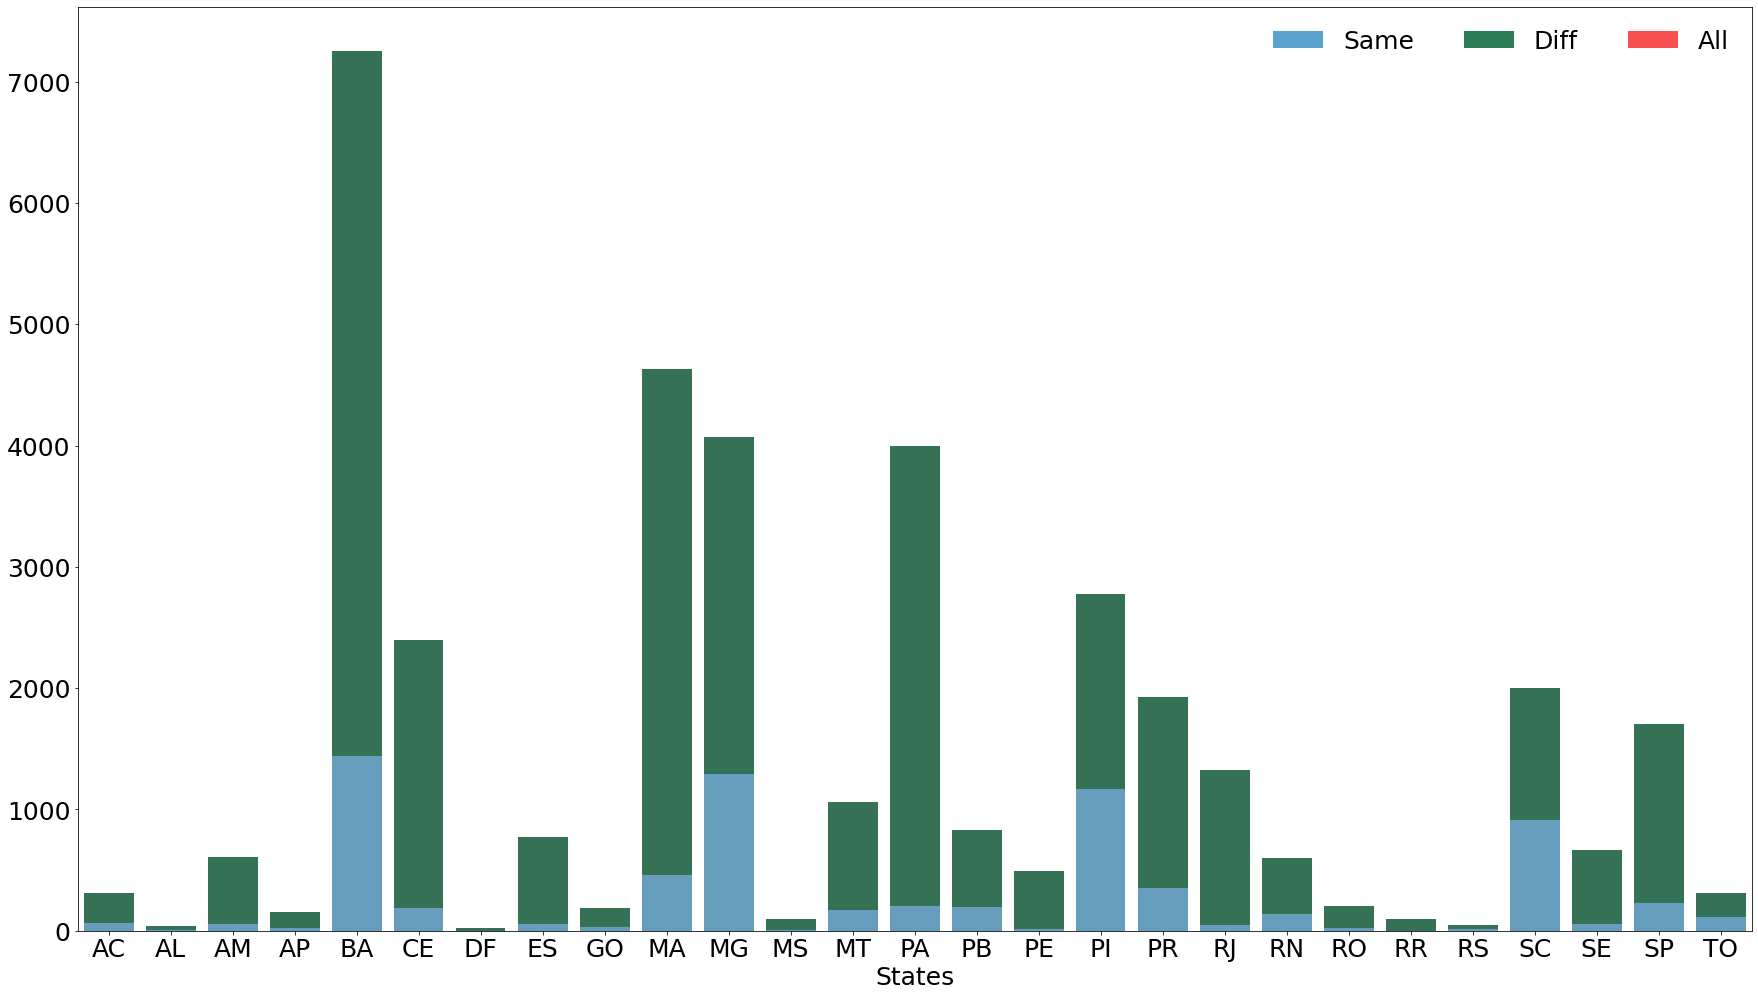

In [49]:
try:
    all_statistics = generate_statistics(election_data,
                                         precision_filter='Others',
                                         area_filter='No Capital',
                                         )
    same_dist = generate_statistics(
        election_data,
        kruskal_filter='Same',
        precision_filter='Others',
        area_filter='No Capital')
    
    
    diff_dist = generate_statistics(
        election_data,
        kruskal_filter='Different',
        precision_filter='Others',
        area_filter='No Capital')
    
    stacked_data(all_statistics,
                 same_dist,
                 diff_dist,
                 field='polling_places',
                 sum_middle = True,
                 legend=['Same', 'Diff', 'All'])
except:
    print("An error occur, please check the selected folder.")

In [50]:
total_size = all_statistics.polling_places.sum()
same_dist_size = same_dist.polling_places.sum()
diff_dist_size = diff_dist.polling_places.sum()
print(
    "Electorate size - Total: {}, Same Dist: {}, Diff Dist: {}".format(
        total_size, same_dist_size, diff_dist_size))

same_dist_perc = 100 * same_dist_size / total_size
diff_dist_perc = 100 * diff_dist_size / total_size
print("Electorate size (%) - Same Dist: {}, Diff Dist: {}".format(same_dist_perc, diff_dist_perc))



Electorate size - Total: 38612, Same Dist: 7280, Diff Dist: 31332
Electorate size (%) - Same Dist: 18.85424220449601, Diff Dist: 81.14575779550398


## Turnout plot
This plot represents the turnout of the electorate per state. It is possible to change the plot by selecting specific areas in the Step 2. The percentages presented in this plot are calculated considering the sum of all states number of voters for the type of precisions selected (Others, TSE, or Rooftop). 

In [51]:
display(output_turnout_plot)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x360 with 2 Axes>', 'i…

## Turnout stacked plot
This plot shows the composition of the turnout electorate by geocoded precision category.
PS: Run this cell after loading the data.

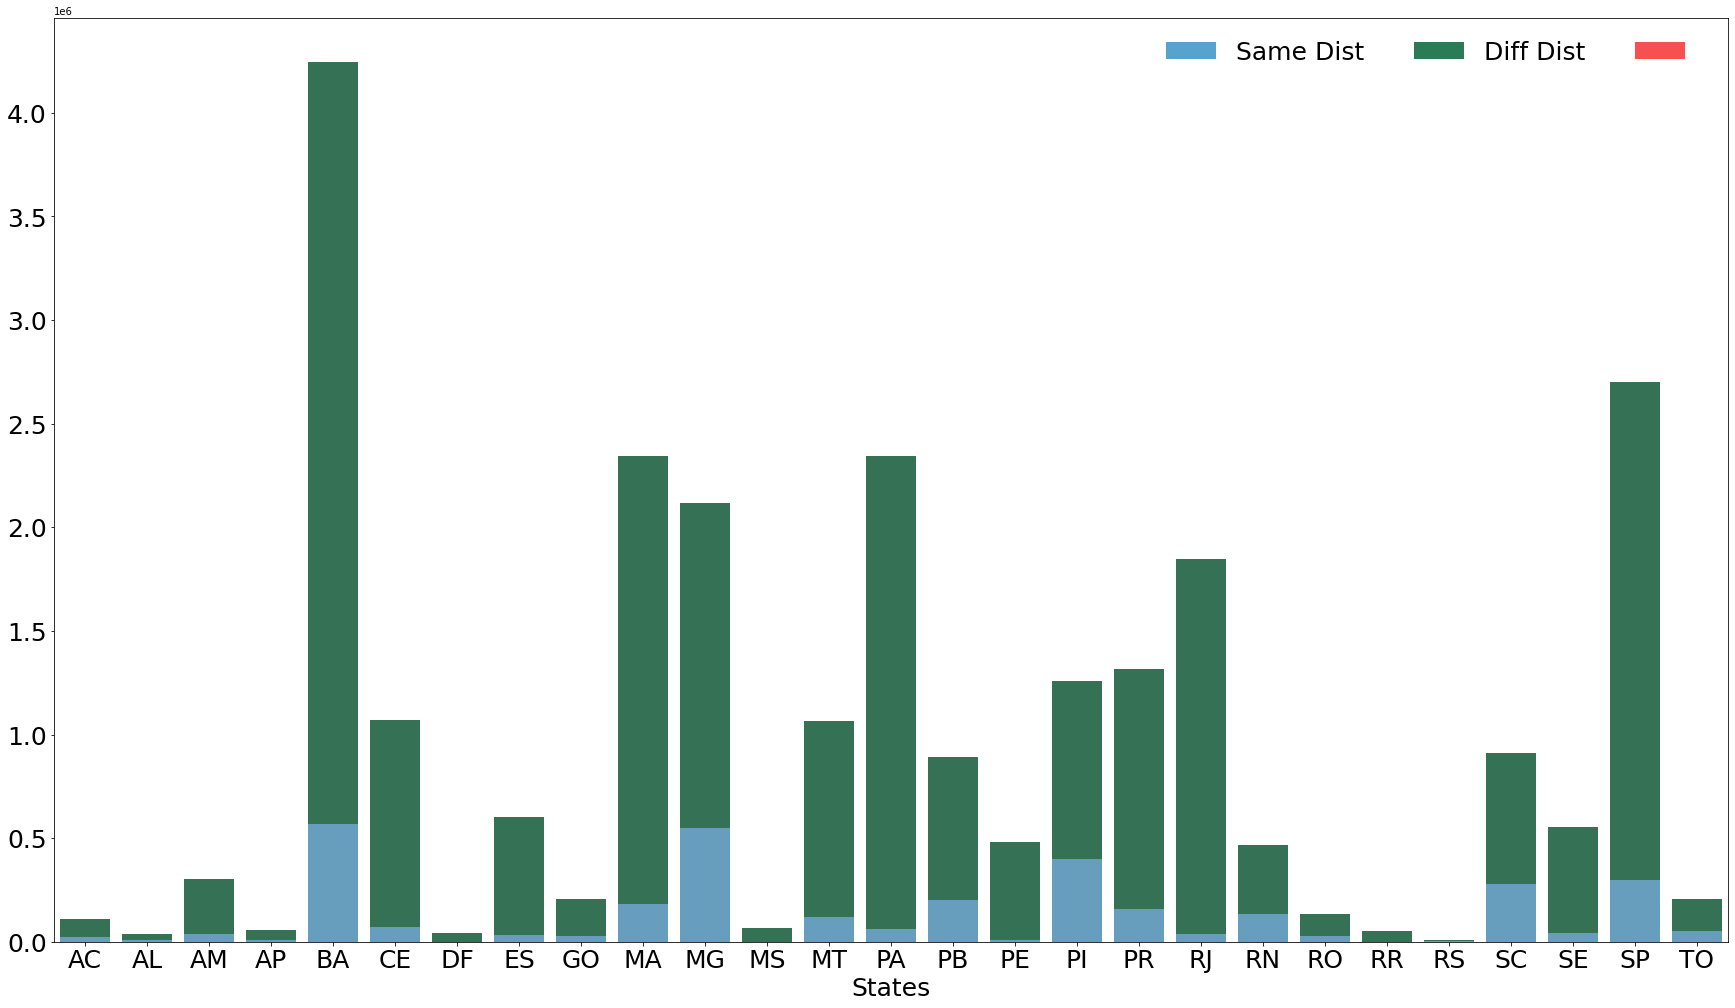

In [52]:
try:
    stacked_data(all_statistics,
                 same_dist,
                 diff_dist,
                 legend=['Same Dist', 'Diff Dist', ''],
                 field='turnout')
except:
    print("An error occur, please check the selected folder.")

In [53]:
total_size = all_statistics.turnout.sum()
same_dist_size = same_dist.turnout.sum()
diff_dist_size = diff_dist.turnout.sum()
print(
    "Electorate size - Total: {}, Same Dist: {}, Diff Dist: {}".format(
        total_size, same_dist_size, diff_dist_size))

same_dist_perc = 100 * same_dist_size / total_size
diff_dist_perc = 100 * diff_dist_size / total_size
print("Electorate size (%) - Same Dist: {}, Diff Dist: {}".format(same_dist_perc, diff_dist_perc))

Electorate size - Total: 25445897, Same Dist: 3321485, Diff Dist: 22124412
Electorate size (%) - Same Dist: 13.053126010845677, Diff Dist: 86.94687398915433


## Precision of same distribution cities stacked plot
This plot shows the composition of the turnout electorate by geocoded precision category.
PS: Run this cell after loading the data.

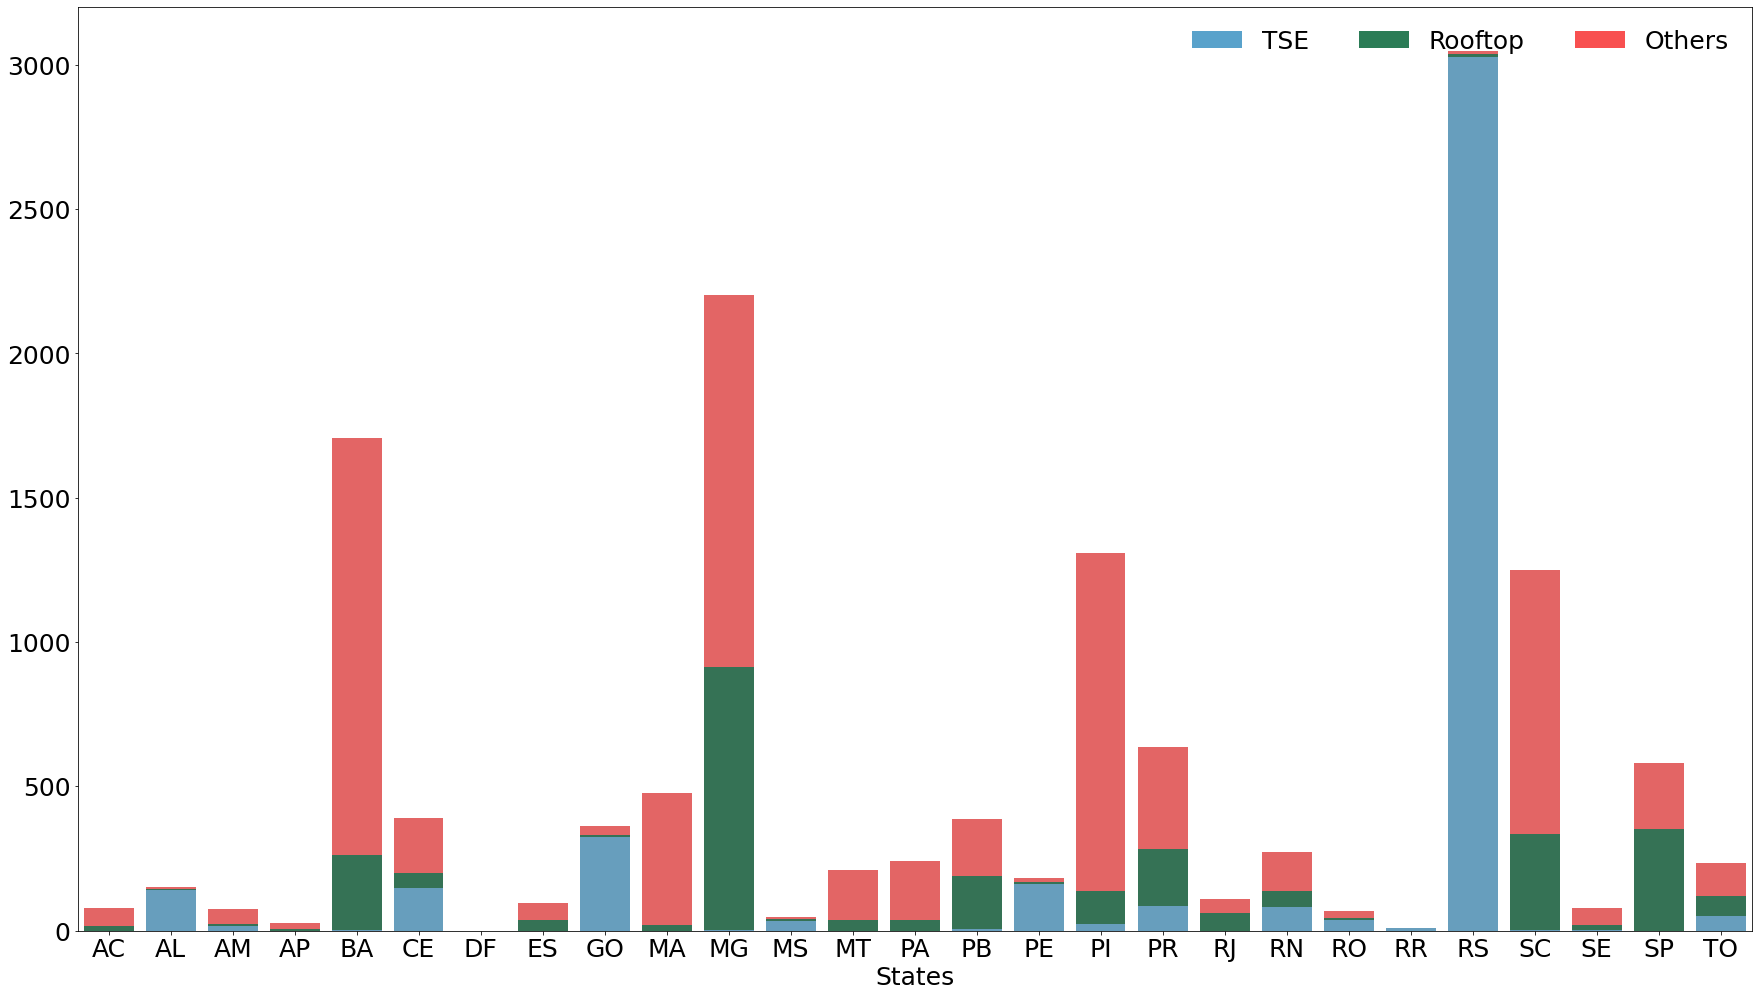

In [64]:
try:
    all_statistics = generate_statistics(election_data,
                                         kruskal_filter='Same',
                                         precision_filter='All',
                                         area_filter='No Capital',
                                         )
    tse_statistics = generate_statistics(
        election_data,
        kruskal_filter='Same',
        precision_filter='TSE',
        area_filter='No Capital')
    
    
    rooftop_statistics = generate_statistics(
        election_data,
        kruskal_filter='Same',
        precision_filter='Rooftop',
        area_filter='No Capital')
    
    stacked_data(all_statistics,
                 tse_statistics,
                 rooftop_statistics,
                 field='polling_places',
                 sum_middle = True,
                 legend=['TSE', 'Rooftop', 'Others'])
except:
    print("An error occur, please check the selected folder.")

In [63]:
total_size = all_statistics.polling_places.sum()
tse_size = tse_statistics.polling_places.sum()
rooftop_size = rooftop_statistics.polling_places.sum()
other_size = total_size - tse_size - rooftop_size
print(
    "Polling places - Total: {}, TSE: {}, Rooftop: {}, Others: {}".format(
        total_size, tse_size, rooftop_size, other_size))

other_perc = 100 * other_size / total_size
tse_perc = 100 * tse_size / total_size
rooftop_perc = 100 * rooftop_size / total_size
print("Polling places (%) - Others: {}, TSE: {}, Rooftop: {}".format(
    other_perc, tse_perc, rooftop_perc))


Polling places - Total: 14256, TSE: 4167, Rooftop: 2809, Others: 7280
Polling places (%) - Others: 51.0662177328844, TSE: 29.22979797979798, Rooftop: 19.70398428731762


# <center> Analysis </center>
